# Grid World RL

* Agent - Jack
* Environment - Mansion with 4x4 rooms
* Rewards - amount of gold collected
* Actions - movement from one room to next one
* State - present room location

Per episode there are fixed number of actions

The env is available in grid_env.py

**Higher exploration rate implies less episodes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from grid_env import GridWorldEnv

In [2]:
env = GridWorldEnv()
env.render()

Present Grid: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



In [3]:
observation_space = env.grid.size
action_space = len(env.actions.keys())
print(observation_space)
print(action_space)

16
4


## Learning the policy

Here a Q-table based learning method is used. Evolutionary algorithm wasn't used in this case beacause they need large number of episodes to converge to an optimal policy.

Value iteration or policy iteration wasn't used because they need the transition probabilities. 

An optimal policy is obtained in q-learning by greedily selecting the highest value for an action while being in a particular state. The exploration rate takes decides the greedy-ness of the policy. In the process all we're doing is maximizing the reward for the agent. 

Higher exploration rate --> Lower number of episodes required to get an optimal policy.

The discount factor decides whether we care about future rewards. If the discount factor is set to 0 then the agent will only care about immediate rewards. This can help the agent to converge faster to an optimal policy if the rewards are not sparse. 

In the given case it was observed that keeping gamma to a low value makes the agent learn the policy faster.

In [4]:
class QLearning():
    """
    Q-table based learning algorithm
    """
    
    def __init__(self, env, exp_rate=0.5, gamma=0.95, lr=0.01):
        self.env = env
        self.exp_rate = exp_rate
        self.gamma = gamma
        self.lr = lr
        
        self.env.exp_rate = self.exp_rate
        
        self.Q = np.zeros((self.env.observation_space, self.env.action_space))
    
    def get_action(self, state, explore = True):
        """Epsilon greedy selection of epsilon in the explore phase.
        Args:
            state (np.ndarray): Environment state.
            explore (bool, optional): True if exploration is required. 
                                      False if not(when we're trying to evaluate the policy set this).
        
        Returns:
            int: action.
        """
        # selecting random action between [up,down,left,right]. 
        # The index below is just the index of the action in the array
        action = np.random.randint(low=0, high=self.env.action_space)
        if explore:    
            if np.random.uniform(0, 1) < self.exp_rate:
                # exploration
                return action
                
            # exploitation: choosing the action which gives most reward. Assuming agent can only see the next state
        if np.argmax(self.Q[state,:]) is not None:
            return np.argmax(self.Q[state, :]) % 4
        else:
            return action
    
    def update(self, transition):
        """
        Updates the Q-Table during the training process. 
        """
        state, action, reward, new_state = transition
        self.Q[state, action] = self.Q[state, action] + self.lr * (reward + self.gamma * np.max(self.Q[new_state, :]) - self.Q[state, action])
    

### Setting parameters for training

In [5]:
episodes = 5000
MAX_ACTIONS = 6 # max actions per episode. given in the question

env = GridWorldEnv()
agent = QLearning(env, exp_rate=0.9, gamma=0.95) # for faster convergence the exploration rate is set to 0.9
ep_rewards = []
temp_actions = list(env.actions.keys()) # list of actions

### Training the policy

In [6]:
for episode in range(episodes):
    episode_rew = 0
    for num_action in range(MAX_ACTIONS):
        # Finding information needed for the learing algorihm
        pre_state = env.state
        action = agent.get_action(env.state)
        next_state = env.step(temp_actions[action], update=True)
        reward = env.getReward(env.state)
        # Updating the Q-table
        agent.update((pre_state, action, reward, next_state))
        
        episode_rew += reward
    if episode % 5000 == 0:
        # the environment is displayed after every 5000 iterations to reduce CPU usage
        env.render()
        print("[DEBUG]: Prev State {}, New State {}".format(pre_state, next_state))
        print()
        
    env.reset() 
    ep_rewards.append(episode_rew)

Present Grid: 
[[0. 0. 0. 0.]
 [5. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[DEBUG]: Prev State [0 0], New State [0 1]



In [7]:
# print(agent.Q)
# print(env.state)
# print(np.argmax(agent.Q[env.state, :]))
# print(agent.Q[env.state, :])

### Evaluating the policy

In [8]:
env.reset()
rew = 0
for num in range(MAX_ACTIONS):
    pre_state = env.state
    action = agent.get_action(env.state, explore=False)
    next_state = env.step(temp_actions[action], update=True)
    reward = env.getReward(env.state)
    rew += reward
    print(next_state)
    env.render()

print("\nReward gained for optimal policy is: {}".format(rew))

[0 1]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[1 1]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[2 1]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 2. 3. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[3 1]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 2. 3. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

[3 2]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 2. 3. 4.]
 [0. 0. 0. 5.]
 [0. 0. 0. 0.]]

[3 3]
Present Grid: 
[[0. 0. 0. 0.]
 [1. 2. 3. 4.]
 [0. 0. 0. 5.]
 [0. 0. 0. 6.]]


Reward gained for optimal policy is: 16


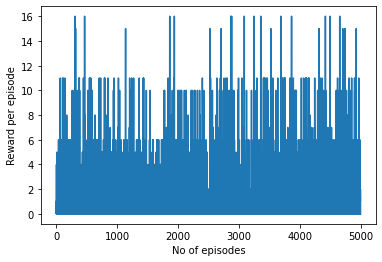

In [9]:
plt.plot(ep_rewards)
plt.xlabel("No of episodes")
plt.ylabel("Reward per episode")
plt.show()